In [1]:
#this code is to segregate the images which previously were not 

import os
import shutil

# Define the path to your dataset folder
dataset_path = './dataset/'

# Define the paths for the new folders
dog_folder = os.path.join(dataset_path, 'dogs')
cat_folder = os.path.join(dataset_path, 'cats')

# Create the folders if they do not exist
os.makedirs(dog_folder, exist_ok=True)
os.makedirs(cat_folder, exist_ok=True)

# Iterate through the files in the dataset folder
for filename in os.listdir(dataset_path):
    # Construct the full file path
    file_path = os.path.join(dataset_path, filename)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        # Move the file to the appropriate folder
        if filename.startswith('dog'):
            shutil.move(file_path, os.path.join(dog_folder, filename))
        elif filename.startswith('cat'):
            shutil.move(file_path, os.path.join(cat_folder, filename))

print("Images have been separated into 'dogs' and 'cats' folders.")

Images have been separated into 'dogs' and 'cats' folders.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers , models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,EarlyStopping
import cv2

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=8
CHANNELS=3
EPOCHS=20

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset" ,
    shuffle=True ,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.


In [5]:
class_name=dataset.class_names
class_name

['cats', 'dogs']

In [6]:
len(dataset)

3125

In [7]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


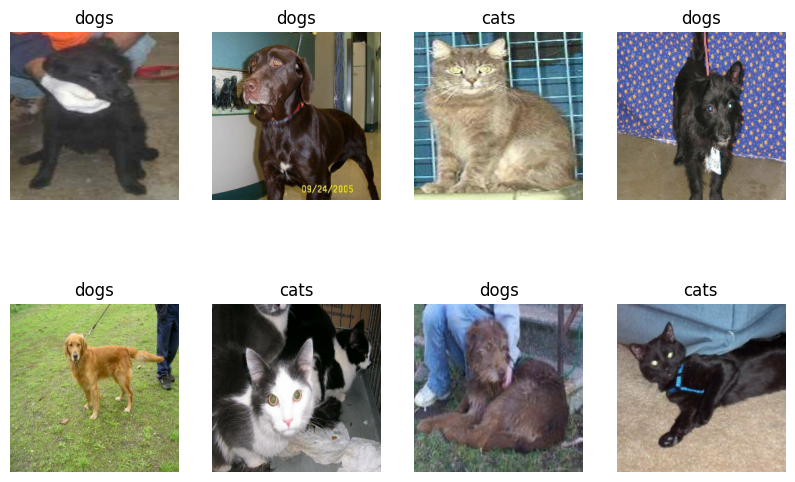

In [8]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size=0.8
len(dataset)*train_size

2500.0

In [10]:

train_ds=dataset.take(625)
len(train_ds)

625

In [11]:
test_ds=dataset.skip(625)
len(test_ds)

2500

In [12]:

val_size=0.1
len(dataset)*val_size

312.5

In [13]:
test_ds=test_ds.skip(78)
len(test_ds)

2422

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) ==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds =ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

2500

In [17]:

len(val_ds)

312

In [18]:
len(test_ds)

313

**Cache, Shuffle, and Prefetch the Dataset**

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds=train_ds.map(
    lambda x,y:(data_augmentation(x , training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes=2

model=models.Sequential([
    resize_rescale,
    #data_augmentation,
    
    layers.Conv2D(64,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=input_shape),
    BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=input_shape),
    BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=input_shape),
    BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=input_shape),
    BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=input_shape),
    BatchNormalization(),
    layers.MaxPooling2D((2,2)),


    



    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    BatchNormalization(),
    layers.Dense(512,activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    BatchNormalization(),
    layers.Dense(256,activation='relu'),
    BatchNormalization(),
    layers.Dense(128,activation='relu'),
    BatchNormalization(),

    layers.Dense(1 , activation='sigmoid'),
    
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 254, 254, 64)         1792      
                                                                 
 batch_normalization (BatchN  (8, 254, 254, 64)        256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (8, 127, 127, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (8, 125, 125, 64)         36928     
                                                                 
 batch_normalization_1 (Batc  (8, 125, 125, 64)       

In [28]:
model.compile(
    optimizer='adam' , 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [30]:
model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    #callbacks=[es_callback]
)

Epoch 1/20
2500/2500 [==============================] - 552s 153ms/step - loss: 0.6895 - accuracy: 0.5827 - val_loss: 0.7240 - val_accuracy: 0.5417
Epoch 2/20
2500/2500 [==============================] - 253s 101ms/step - loss: 0.6307 - accuracy: 0.6496 - val_loss: 0.9030 - val_accuracy: 0.5312
Epoch 3/20
2500/2500 [==============================] - 249s 100ms/step - loss: 0.6025 - accuracy: 0.6798 - val_loss: 0.6490 - val_accuracy: 0.6234
Epoch 4/20
2500/2500 [==============================] - 246s 98ms/step - loss: 0.5681 - accuracy: 0.7115 - val_loss: 0.6227 - val_accuracy: 0.6675
Epoch 5/20
2500/2500 [==============================] - 246s 98ms/step - loss: 0.5292 - accuracy: 0.7397 - val_loss: 0.6480 - val_accuracy: 0.6859
Epoch 6/20
2500/2500 [==============================] - 247s 99ms/step - loss: 0.4940 - accuracy: 0.7671 - val_loss: 0.6333 - val_accuracy: 0.7051
Epoch 7/20
2500/2500 [==============================] - 248s 99ms/step - loss: 0.4662 - accuracy: 0.7854 - val_loss

In [31]:
score=model.evaluate(test_ds)


313/313 [==============================] - 28s 28ms/step - loss: 0.6441 - accuracy: 0.6909


In [32]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

1/1 [==============================] - 0s 23ms/step
The image represents a Cat


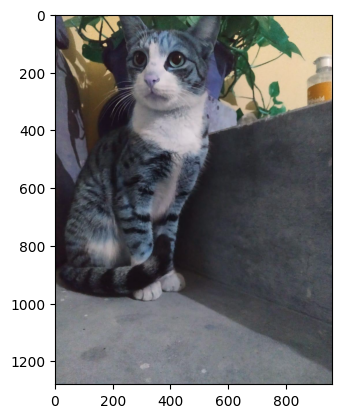

In [45]:
import numpy as np
input_image = cv2.imread('test_img2.jpg')
plt.imshow(input_image)

input_image_resize = cv2.resize(input_image, (IMAGE_SIZE,IMAGE_SIZE))
input_image_scaled = input_image_resize/255
image = np.expand_dims(input_image_scaled, axis=0)


input_prediction = model.predict(image)

input_pred_label = np.argmax(input_prediction)

if input_pred_label ==0:
  print('The image represents a Cat')

else:
  print('The image represents a Dog')

